# Hands-On Time Series Workshop: *Identifying Arrhythmia Using Electrocardiogram Data*

In this workshop we will be using time series electrocardiogram (ECG) data to classify Arrhythmia. 

The workshop is split into the following parts: 
1. Load and explore the dataset
2. Pre-processing
3. Training and saving the model 
4. Deploying the model
5. Creating and adding a drift detector! 

The data pre-processing and model building are based upon the hardwork of Kaggle user Gregoire DC. You can see the original notebook [here](https://www.kaggle.com/gregoiredc/arrhythmia-on-ecg-classification-using-cnn). 

In [1]:
# Colab has a load of packages pre-loaded into the environment. Installing the additional ones we require here.
!pip install seldon-deploy-sdk==1.4.1
!pip install alibi-detect==0.6.1
!pip install seaborn
!pip install dill

     |████████████████████████████████| 150 kB 2.9 MB/s eta 0:00:01
  Using cached scikit_learn-0.24.2-cp37-cp37m-macosx_10_13_x86_64.whl (7.2 MB)
  Using cached grpcio-1.32.0-cp37-cp37m-macosx_10_9_x86_64.whl (3.3 MB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: alibi-detect
    Found existing installation: alibi-detect 0.6.2
    Uninstalling alibi-detect-0.6.2:
      Successfully uninstalled alibi-detect-0.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.9.0 requires scikit-learn>=1.0.1, but you have scikit-learn 0.24.2 which is inco

In [60]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn for scoring models
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.utils import resample

# Keras acts as the model training library
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Drift detection
from alibi_detect.cd import MMDDrift, KSDrift
from alibi_detect.cd.base import BaseUnivariateDrift
from alibi_detect.utils.saving import save_detector, load_detector

# Seldon Deploy SDK 
from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, DriftDetectorApi, ModelMetadataServiceApi
from seldon_deploy_sdk.auth import OIDCAuthenticator

# For loading serialised objects
import dill 

# Utility library
import itertools

## Data Exploration

Download and unpack training and test data

In [3]:
!wget https://storage.googleapis.com/seldon-koz-ecg/data/mitbih_test.csv.zip
!wget https://storage.googleapis.com/seldon-koz-ecg/data/mitbih_train.csv.zip
!unzip 'mitbih_test.csv.zip'
!unzip 'mitbih_train.csv.zip'

--2022-05-20 08:38:42--  https://storage.googleapis.com/seldon-koz-ecg/data/mitbih_test.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.176.208, 142.251.40.240, 142.251.32.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.176.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17444159 (17M) [application/zip]
Saving to: ‘mitbih_test.csv.zip’

mitbih_test.csv.zip 100%[===================>]  16.64M  7.16MB/s    in 2.3s    

2022-05-20 08:38:44 (7.16 MB/s) - ‘mitbih_test.csv.zip’ saved [17444159/17444159]

--2022-05-20 08:38:45--  https://storage.googleapis.com/seldon-koz-ecg/data/mitbih_train.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.176.208, 142.251.40.240, 142.251.32.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.176.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69854187 (67M) [application/zip]
Saving to: 

This workshop uses ECG data collected from Beth Israel Hospital Arrhythmia Laboratory between 1975 and 1979. The subjects were 25 men aged 32 to 89 years, and 22 women aged 23 to 89 years. Data was collected using a Holter monitor. You can find out more about the dataset [here](https://physionet.org/content/mitdb/1.0.0/).

**About the dataset**

* Number of Samples: 109446
* Number of Categories: 5
* Sampling Frequency: 125Hz
* Data Source: Physionet's MIT-BIH Arrhythmia Dataset
* Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

**Labels**

* N : Non-ecotic beats (normal beat) 
* S : Supraventricular ectopic beats 
* V : Ventricular ectopic beats 
* F : Fusion Beats 
* Q : Unknown Beats

More understanding around the labels: an ectopic beat is an extra beat which occurs prior to a normal beat. Fusion beats are a hybrid complex when a supraventricular (top section of your heart) and a ventricular (bottom section of the heart) impulse coincide. 

Next, we read the training and test data into Pandas.

In [4]:
train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


Each row is a single beat cycle, with each of the features a reading of the electrical activity across that cycle.

In [5]:
train_df.iloc[0]

0      0.977941
1      0.926471
2      0.681373
3      0.245098
4      0.154412
         ...   
183    0.000000
184    0.000000
185    0.000000
186    0.000000
187    0.000000
Name: 0, Length: 188, dtype: float64

Converting the labels to integers, and counting each of their values. 

In [6]:
train_df[187]=train_df[187].astype(int)
label_counts=train_df[187].value_counts()
print(label_counts)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


Visualising the label imbalance with a doughnut chart. 

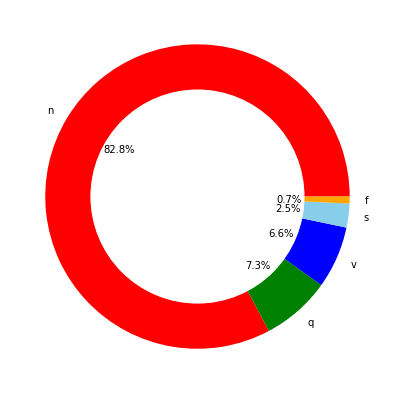

In [7]:
plt.figure(figsize=(14,7))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(label_counts, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Clearly, there is a large imbalance in the labels with over 80% of them representing normal heartbeats. This imbalance needs to be rectified in order to create a model which can accurately pick out different types of arrhythmia. 

Therefore, we select 20,000 normal heartbeat samples. We then resample the remaining classes with replacement to have a resultant dataset with an equal proporition of each class. 

In [8]:
random_state = 42

label_dfs = {}

for i in label_counts.index:
    label_dfs[i] = train_df[train_df[187]==i]

# The first class has 72k observations, so we sample down to 20000
label_dfs[0] = label_dfs[0].sample(n=20000, random_state=random_state)

# The remaining classes have less than 20000 observations and therefore we resample with replacement. 
for i in [1, 2, 3, 4]:
    label_dfs[i] = resample(label_dfs[i], replace=True, n_samples=20000, random_state=random_state)
    
rebalanced_df = pd.concat([i for i in label_dfs.values()])
rebalanced_label_counts = rebalanced_df[187].value_counts()
rebalanced_label_counts

0    20000
4    20000
2    20000
1    20000
3    20000
Name: 187, dtype: int64

Next we visualise a single instance of each class to see the difference in the signatures which they present.

To do so, we create a DataFrame with a single obeservation of each of the classes. 

In [9]:
sample_df = rebalanced_df.groupby(187, group_keys=False).apply(lambda train_df: train_df.sample(n=1))
sample_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
22793,0.832714,0.635688,0.382900,0.137546,0.000000,0.022305,0.052045,0.137546,0.144981,0.163569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73002,1.000000,0.731092,0.246499,0.056022,0.089636,0.061625,0.019608,0.014006,0.028011,0.019608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
79841,0.766879,0.729936,0.466242,0.187261,0.067516,0.011465,0.000000,0.045860,0.132484,0.217834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80723,1.000000,0.932540,0.337302,0.121032,0.079365,0.063492,0.035714,0.045635,0.021825,0.029762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
82501,0.739130,0.633540,0.571429,0.577640,0.524845,0.487578,0.434783,0.391304,0.288820,0.167702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


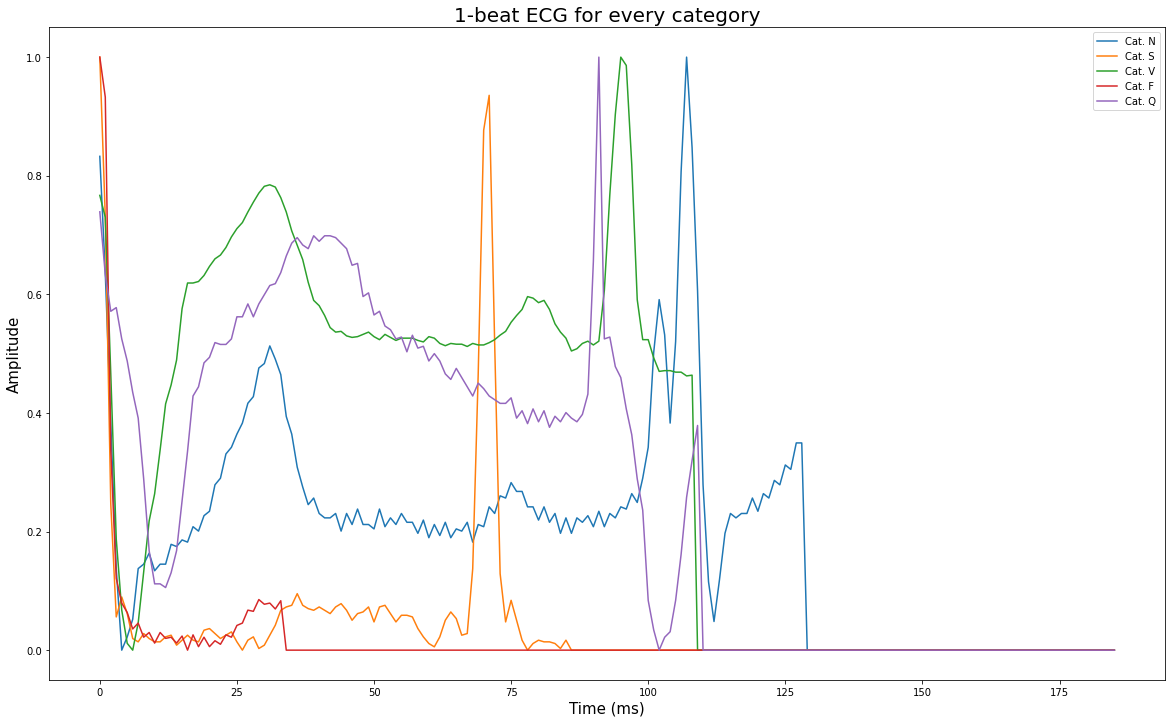

In [10]:
plt.figure(figsize=(20,12))

plt.plot(sample_df.iloc[0,:186], label="Cat. N")
plt.plot(sample_df.iloc[1,:186], label="Cat. S")
plt.plot(sample_df.iloc[2,:186], label="Cat. V")
plt.plot(sample_df.iloc[3,:186], label="Cat. F")
plt.plot(sample_df.iloc[4,:186], label="Cat. Q")

plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)

plt.show()

The final piece of pre-processing we do is to add Gaussian noise to our data. This will help us to generalise to unseen data better, by forcing our model to work harder to detect meaningful signal from random noise. 

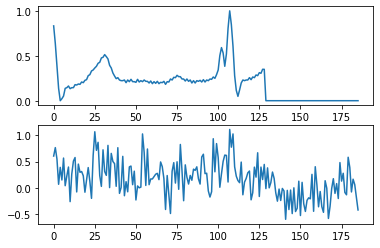

In [15]:
def add_gaussian_noise(signal):
    noise = np.random.normal(0, 0.3, 186)
    return (signal + noise)

single_sample = sample_df.iloc[0,:186]
noisy_sample=add_gaussian_noise(single_sample)

plt.subplot(2, 1, 1)
plt.plot(sample_df.iloc[0,:186])

plt.subplot(2, 1, 2)
plt.plot(noisy_sample)

plt.show()

Applying the Gaussian noise to the training data. 

In [16]:
target_train=train_df[187]
target_test=test_df[187]

y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [17]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
    
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

## Model Training
For the sake of time we will not train our CNN live and use a pre-trained model. 

This pre-trained model was trained with the following architecture: 
```
# Input
in_shape = (X_train.shape[1],1)
inputs_cnn = Input(shape=(in_shape), name='inputs_cnn')

# 1st convolutional layer
conv1_1 = Convolution1D(64, (6), activation='relu', input_shape=in_shape)(inputs_cnn)
conv1_1 = BatchNormalization()(conv1_1)
pool1 = MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)

# 2nd convolutional layer
conv2_1 = Convolution1D(64, (3), activation='relu', input_shape=in_shape)(pool1)
conv2_1 = BatchNormalization()(conv2_1)
pool2 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)

# 3rd convolutional layer
conv3_1 = Convolution1D(64, (3), activation='relu', input_shape=in_shape)(pool2)
conv3_1 = BatchNormalization()(conv3_1)
pool3 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
flatten = Flatten()(pool3)

# Output
dense_end1 = Dense(64, activation='relu')(flatten)
dense_end2 = Dense(32, activation='relu')(dense_end1)
main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)

```
The best model was saved using early stopping at epoch 25 of 40. We load back this pretrained model as well as the training history to explore. 

In [11]:
!mkdir pretrained_model
!gsutil cp -r gs://tom-seldon-examples/time-series-workshop/1 pretrained_model
!gsutil cp gs://tom-seldon-examples/time-series-workshop/history.dill history.dill

Copying gs://tom-seldon-examples/time-series-workshop/1/saved_model.pb...
Copying gs://tom-seldon-examples/time-series-workshop/1/variables/variables.data-00000-of-00001...
Copying gs://tom-seldon-examples/time-series-workshop/1/variables/variables.index...
\ [3 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 3 objects/1.8 MiB.                                      
Copying gs://tom-seldon-examples/time-series-workshop/history.dill...
/ [1 files][  484.0 B/  484.0 B]                                                
Operation completed over 1 objects/484.0 B.                                      


In [12]:
model = load_model("pretrained_model/1")

with open("history.dill", "rb") as file:
    history = dill.load(file)

2022-05-20 09:16:10.652835: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-20 09:16:10.653101: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We next define a function to evaluate our model training efforts. This plots the training and validation accuracy and losses of our model. 

In [13]:
def evaluate_model(history, X_test, y_test, model):
    """
    Plots line graphs for the training/validation accuracy and losses. 
    """
    scores = model.evaluate((X_test), y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    fig1, ax_acc = plt.subplots()
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']    

Evaluate the model and make predictions.

2022-05-20 09:16:43.142782: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Accuracy: 95.80%


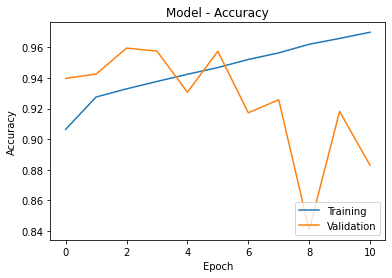

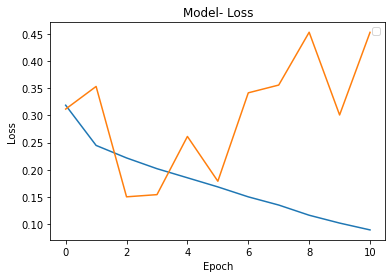

In [18]:
evaluate_model(history, X_test, y_test, model)

Finally we plot a normalised confusion matrix to understand better how our model performs across the multiple classes. 

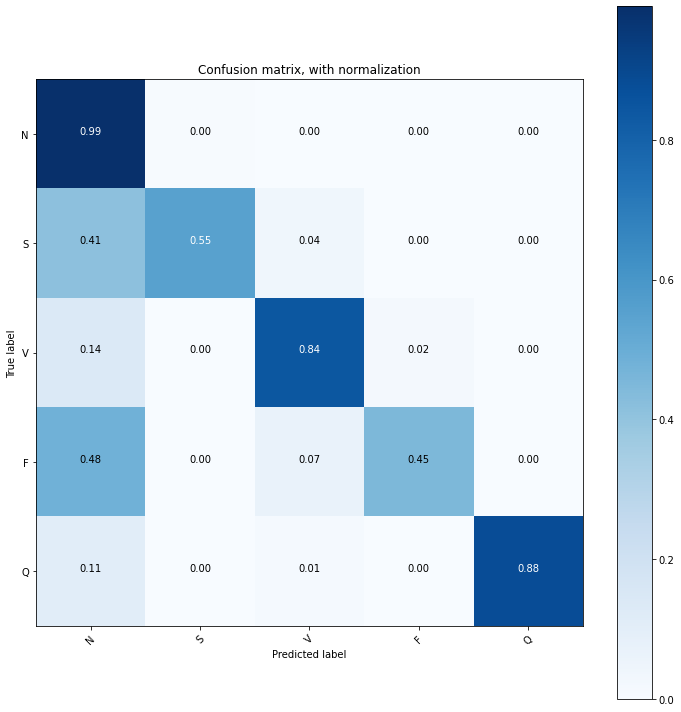

In [19]:
def plot_confusion_matrix(cm, 
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the normalised confusion matrix.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred=model.predict(X_test)
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, with normalization')
plt.show()

# Deploying the Model
We now want to serve our model on the Seldon infrastructure.

For this we can use the pre-built Tensorflow container image, which allows us to rapidly deploy our newly trained model using TFServing. 

Firstly we save our model locally i.e. `model.save("pretrained_model")` 

We can then push it a cloud storage bucket ready for deployment. This has been done ahead of time and the model can be accessed at the following URI `gs://tom-seldon-examples/time-series-workshop/`

-----------

A couple of considerations: 
1. The TF pre-built image uses the SavedModel format, not Kera's older HDF5 format.
2. TFServing expects a subdirectory referring to the model version which then contains the model artifacts. You can create this manually when pushing to cloud storage e.g. `gs://tom-seldon-examples/time-series-workshop/1/saved_model.pb`

----------

We are now ready to deploy to Seldon. We will do this via the Python SDK provided to interact with Seldon Deploy. 

In [ ]:
!mkdir pretrained_model
!gsutil cp -r gs://tom-seldon-examples/time-series-workshop/1 pretrained_model
!gsutil cp gs://tom-seldon-examples/time-series-workshop/history.dill history.dill

In [84]:
SD_IP = "34.73.137.78"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

In [43]:
YOUR_NAME = "josh" # Replace with your name
MODEL_NAME = "ecg-things" # Replace with your model name

DEPLOYMENT_NAME = f"{YOUR_NAME}-{MODEL_NAME}"
MODEL_LOCATION = f"gs://tom-seldon-examples/time-series-workshop/"

NAMESPACE = "seldon-demos"

PREPACKAGED_SERVER = "TENSORFLOW_SERVER"

CPU_REQUESTS = "0.1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "0.1"
MEMORY_LIMITS = "1Gi"


In [44]:
mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol": "seldon",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "implementation": PREPACKAGED_SERVER,
                    "modelUri": MODEL_LOCATION,
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "endpoint": {
                        "type": "REST"
                    },
                    "parameters": [],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}

In [115]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'josh-ecg-things',
              'namespace': 'seldon-demos',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'josh-ecg-things',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec': None,


Our model should now be running as a fully fledged microservice. We can now log into Seldon Deploy:

* URL: http://34.141.146.222/seldon-deploy/
* Username: admin@seldon.io
* Password: 12341234

We can then test our new deployment using the request here --> You can download the file and upload it

[Link to Prediction](https://github.com/SeldonIO/deploy-workshops/blob/ecg-deploy-model-catalog/time-series/prediction.json)


## Adding a Metadata to the model catalog
Seldon Deploy has a model catalog where all deployed models are automatically registered. The model catalog can store custom metadata as well as prediction schemas for your models. 

Metadata promotes lineage from across different machine learning systems, aids knowledge transfer between teams, and allows for faster deployment. Meanwhile, prediction schemas allow Seldon Deploy to automatically profile tabular data into histograms, allowing for filtering on features to explore trends. 


In [85]:
model_catalog_metadata = {
      "URI": MODEL_LOCATION,
      "name": f"Hello-{DEPLOYMENT_NAME}-model",
      "version": "v1.1",
      "artifactType": "TENSORFLOW",
      "taskType": "ECG Classification",
      "tags": {
        "auto_created": "true",
        "author": f"{YOUR_NAME}"
      },
      "metrics": {},
      "project": "default",
      
    }

model_catalog_metadata

{'URI': 'gs://tom-seldon-examples/time-series-workshop/',
 'name': 'Hello-josh-ecg-things-model',
 'version': 'v1.1',
 'artifactType': 'TENSORFLOW',
 'taskType': 'ECG Classification',
 'tags': {'auto_created': 'true', 'author': 'josh'},
 'metrics': {},
 'project': 'default'}

Next, using the metadata API you can add this to the model which you have just created in Seldon.

In [86]:
metadata_api = ModelMetadataServiceApi(auth())
metadata_api.model_metadata_service_update_model_metadata(model_catalog_metadata)

{}

You can then list the metadata via the API, or view it in the UI, to confirm that it has been successfully added to the model. 

In [68]:
metadata_response = metadata_api.model_metadata_service_list_model_metadata(uri=MODEL_LOCATION)
metadata_response

{'models': [{'artifact_type': 'TENSORFLOW',
             'creation_time': datetime.datetime(2022, 5, 20, 14, 53, 10, 205020, tzinfo=tzutc()),
             'metrics': {},
             'name': 'josh-ecg-things-model',
             'prediction_schema': None,
             'project': 'default',
             'tags': {'author': 'josh', 'auto_created': 'true'},
             'task_type': 'ECG Classification',
             'uri': 'gs://tom-seldon-examples/time-series-workshop/',
             'version': 'v1.1'}],
 'next_page_token': ''}

## Drift Detection

Although powerful, modern machine learning models can be sensitive. Seemingly subtle changes in a data distribution can destroy the performance of otherwise state-of-the art models, which can be especially problematic when ML models are deployed in production. Typically, ML models are tested on held out data in order to estimate their future performance. Crucially, this assumes that the process underlying the input data `X` and output data `Y` remains constant.

Drift can be classified into the following types:
* **Covariate drift**: Also referred to as input drift, this occurs when the distribution of the input data has shifted `P(X) != Pref(X)`, whilst `P(Y|X) = Pref(Y|X)`. This may result in the model giving unreliable predictions.

* **Prior drift**: Also referred to as label drift, this occurs when the distribution of the outputs has shifted `P(Y) != Pref(Y)`, whilst `P(X|Y) = Pref(X|Y)`. This can affect the model’s decision boundary, as well as the model’s performance metrics.

* **Concept drift**: This occurs when the process generating `Y` from `X` has changed, such that `P(Y|X) != Pref(Y|X)`. It is possible that the model might no longer give a suitable approximation of the true process.

-----------------

In this instance we will train a Kolmgorov-Smirnov drift detector to pick up on covariate drift. The KS Drift detector applies a two-sample KS test to compare the distance between the new probability distribution and the reference distribution. 

This is done on a feature by feature basis and the results are then aggregated using a correction, i.e. Bonferroni, to determine whether drift has occurred overall within the sample. 

We will use the training set as our reference distribution. Creating our drift detector is then as simple as writing a single line of code:

In [46]:
dd = KSDrift(X_train, p_val=.05, correction='bonferroni')

We can then easily get a prediction against a given batch of data and determine whether drift has occurred or not!

In [47]:
preds = dd.predict(X_train)
labels = ["No", "Yes"]

print(f'Drift? {labels[preds["data"]["is_drift"]]}')

Drift? No


As expected, when using our training data as the new distribution we do not detect any drift. 

However, if we passed the instances of solely the ventricular ecoptic beats (class 2) we can see drift is now detected. 

In [113]:
new_preds = dd.predict(label_dfs[2].values)

print(f'Drift? {labels[new_preds["data"]["is_drift"]]}')

Drift? Yes


Inspecting the `new_preds` object we can see that it contains the `is_drift` binary flag indicating whether drift has been detected after applying the Bonferroni correction to the feature wise distance.

In [94]:
new_preds

{'data': {'is_drift': 1,
  'distance': array([0.41, 0.26, 0.18, 0.32, 0.28, 0.28, 0.28, 0.29, 0.29, 0.29, 0.3 ,
         0.3 , 0.29, 0.28, 0.28, 0.27, 0.26, 0.26, 0.26, 0.25, 0.25, 0.24,
         0.24, 0.24, 0.23, 0.23, 0.22, 0.22, 0.21, 0.21, 0.2 , 0.2 , 0.2 ,
         0.19, 0.19, 0.19, 0.2 , 0.22, 0.24, 0.26, 0.29, 0.3 , 0.31, 0.32,
         0.32, 0.33, 0.33, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34, 0.34,
         0.34, 0.34, 0.33, 0.33, 0.32, 0.32, 0.31, 0.31, 0.3 , 0.3 , 0.29,
         0.29, 0.29, 0.29, 0.29, 0.29, 0.28, 0.28, 0.29, 0.28, 0.28, 0.27,
         0.26, 0.25, 0.25, 0.25, 0.25, 0.26, 0.26, 0.26, 0.27, 0.27, 0.27,
         0.28, 0.28, 0.29, 0.29, 0.3 , 0.3 , 0.3 , 0.31, 0.31, 0.31, 0.31,
         0.31, 0.32, 0.32, 0.32, 0.33, 0.34, 0.35, 0.35, 0.36, 0.36, 0.37,
         0.38, 0.37, 0.38, 0.38, 0.39, 0.39, 0.39, 0.39, 0.4 , 0.4 , 0.4 ,
         0.41, 0.41, 0.41, 0.42, 0.42, 0.43, 0.43, 0.43, 0.44, 0.44, 0.44,
         0.44, 0.44, 0.45, 0.45, 0.45, 0.45, 0.45, 0.46, 0.46, 

We can easily save the artifacts related to our drift detector using Alibi Detect's `save_detector` utility function. 

In [116]:
save_detector(dd, "drift_detector")

We then push this to our GCS bucket ready for deployment alongside our model. 

Remember to replace `<YOUR NAME>` with the same name as before! 

In [117]:
!gsutil cp -r drift_detector gs://tom-seldon-examples/time-series-workshop/pretrained-drift/josh

Copying file://drift_detector/KSDrift.pickle [Content-Type=application/octet-stream]...
Copying file://drift_detector/meta.pickle [Content-Type=application/octet-stream]...
- [2 files][124.2 MiB/124.2 MiB]    8.3 MiB/s                                   
Operation completed over 2 objects/124.2 MiB.                                    


We can then use the Seldon Deploy SDK to configure and deploy our shiny new drift detector!

In [120]:
# TO DO: Add code to deploy the drift detector!
DD_URI = f'gs://tom-seldon-examples/time-series-workshop/pretrained-drift/josh'
DD_NAME = "ks-drift"

dd_config = {'config': {'basic': 
                        {'drift_batch_size': '2',
                         'storage_uri': DD_URI},
                        'deployment': {'protocol': 'seldon.http'}
                        },
             'deployment_name': DEPLOYMENT_NAME,
             'detector_type': 'drift',
             'name': DD_NAME,
             'namespace': NAMESPACE
            }

In [121]:
dd_api = DriftDetectorApi(auth())

dd_api.create_drift_detector_seldon_deployment(name=DEPLOYMENT_NAME, 
                                               namespace=NAMESPACE, 
                                               detector_data=dd_config)

{'config': {'basic': {'drift_batch_size': '2',
                      'env_secret_ref': None,
                      'storage_uri': 'gs://tom-seldon-examples/time-series-workshop/pretrained-drift/josh'},
            'deployment': {'event_source': 'io.seldon.serving.josh-ecg-things-ks-drift',
                           'event_type': 'io.seldon.serving.inference.drift',
                           'http_port': '8080',
                           'model_name': 'ks-drift',
                           'prom_scraping': True,
                           'protocol': 'seldon.http',
                           'reply_url': 'http://seldon-request-logger.seldon-logs.svc.cluster.local:80',
                           'user_permission': 8888}},
 'deployment_kind': 'SeldonDeployment',
 'deployment_name': 'josh-ecg-things',
 'detector_type': 'drift',
 'name': 'ks-drift',
 'namespace': 'seldon-demos'}

You can then kick off Drift by submitting a few requests using the regular prediction and the drift prediction

[Drift Prediction](https://raw.githubusercontent.com/SeldonIO/deploy-workshops/ecg-deploy-model-catalog/time-series/prediction-drift.json)